In [10]:
import os, sys, time, copy
import numpy as np
import matplotlib.pyplot as plt

import myokit
sys.path.append('../../../')
sys.path.append('../../../Protocols')
sys.path.append('../../../Models')
sys.path.append('../../../Lib')
import protocol_lib, vc_protocols
import mod_trace
from kylie2017IKr import Kylie2017IKr

In [11]:
# V = model.voltage(times)
g = 0.1524 * 1e3 # [pA/V]
p1 = 2.26e-4 * 1e3 # [1/s]
p2 = 0.0699 * 1e3  # [1/V]
p3 = 3.45e-5 * 1e3 # [1/s]
p4 = 0.05462 * 1e3 # [1/V]
p5 = 0.0873 * 1e3  # [1/s]
p6 = 8.91e-3 * 1e3 # [1/V]
p7 = 5.15e-3 * 1e3 # [1/s]
p8 = 0.03158 * 1e3 # [1/V]

parameters = { 
    'ikr.g' : 0.1524 * 1e3,
    'ikr.p1' : 2.26e-4 * 1e3, 
    'ikr.p2' : 0.0699 * 1e3 ,  
    'ikr.p3' : 3.45e-5 * 1e3,
    'ikr.p4' : 0.05462 * 1e3 ,
    'ikr.p5' : 0.0873 * 1e3 ,
    'ikr.p6' : 8.91e-3 * 1e3 ,
    'ikr.p7' : 5.15e-3 * 1e3,
    'ikr.p8' : 0.03158 * 1e3 ,
}

parameters = { 
    'ikr.g' : 5.65246434e+04,
    'ikr.p1' : 1.09827235e-01, 
    'ikr.p2' : 9.10730308e+01,  
    'ikr.p3' : 6.66694679e-02 ,
    'ikr.p4' : 3.55734178e+01 ,
    'ikr.p5' : 6.56912022e+01 ,
    'ikr.p6' : 3.31502009e+01 ,
    'ikr.p7' : 1.13545248e+01,
    'ikr.p8' : 2.90442393e+01 ,
}

dt = 0.0002
t_eval = np.arange(77000)*dt  # times = np.linspace(0, 15.4, 77000)
t_span = (0, t_eval.max())

In [12]:
import simulator_myokit
import vc_protocols_for_myokit
'''
Simulation with Myokit
'''
model_path = "../../../mmt-model-files/kylie-2017-IKr.mmt" 
m_myokit, protocol, script = myokit.load(model_path)
protocol = vc_protocols.leak_staircase()

# model, protocol, _ = vc_protocols_for_myokit.leak_staircase(model)
sim_myokit = simulator_myokit.Simulator(m_myokit, protocol, max_step=1.0, abs_tol=1e-08, rel_tol=1e-10, vhold=-80e-3 )  # 1e-12, 1e-14  # 1e-08, 1e-10
sim_myokit.name = "kylie-2017-IKr"

start_time = time.time()

sim_myokit.set_simulation_params( parameters)
y0 = sim_myokit.pre_simulate( 100, sim_type=1)
d_myokit = sim_myokit.simulate(t_eval.max()+dt, log_times=t_eval, extra_log=['ikr.IKr', 'ikr.open', 'ikr.active'])
population_by_continent = {
    'O': d_myokit['ikr.open']*d_myokit['ikr.active'],
    'I': d_myokit['ikr.open']*(1-d_myokit['ikr.active']),
    'C': (1-d_myokit['ikr.open'])*d_myokit['ikr.active'],
    'IC': (1-d_myokit['ikr.open'])*(1-d_myokit['ikr.active']),    
}
print("--- %s seconds ---"%(time.time()-start_time))

--- 0.720163106918335 seconds ---


In [13]:
y0

[6.554605651425557e-05, 0.961587643919374]

In [14]:
import simulator_scipy
'''
Simulation with solve_ivp
'''
protocol = vc_protocols.leak_staircase()
m_scipy = Kylie2017IKr(protocol)
sim_scipy = simulator_scipy.Simulator(m_scipy)

start_time = time.time()

sim_scipy.model.set_initial_values( y0=y0 )
sim_scipy.model.set_params(parameters['ikr.g'], 
                           parameters['ikr.p1'], 
                           parameters['ikr.p2'], 
                           parameters['ikr.p3'], 
                           parameters['ikr.p4'], 
                           parameters['ikr.p5'],
                           parameters['ikr.p6'], 
                           parameters['ikr.p7'], 
                           parameters['ikr.p8'])
# y0 = simulator.pre_simulate( pre_step=100, protocol='constant' )        
solution = sim_scipy.simulate(t_span=t_span, t_eval=t_eval, method='LSODA', max_step=8e-4, atol=1e-08, rtol=1e-10) # 1e-12, 1e-14  # 1e-08, 1e-10
  
population_by_continent = {
    'O': m_scipy.open*m_scipy.active,
    'I': m_scipy.open*(1-m_scipy.active),
    'C': (1-m_scipy.open)*m_scipy.active,
    'IC': (1-m_scipy.open)*(1-m_scipy.active),    
}
print("--- %s seconds ---"%(time.time()-start_time))

--- 3.7437527179718018 seconds ---


In [15]:
import simulator_euler
protocol = vc_protocols.leak_staircase()
m_euler = Kylie2017IKr(protocol)
sim_euler = simulator_euler.Simulator(m_euler)

start_time = time.time()
sim_euler.model.set_initial_values( y0=y0 )
sim_euler.model.set_params(parameters['ikr.g'], 
                           parameters['ikr.p1'], 
                           parameters['ikr.p2'], 
                           parameters['ikr.p3'], 
                           parameters['ikr.p4'], 
                           parameters['ikr.p5'],
                           parameters['ikr.p6'], 
                           parameters['ikr.p7'], 
                           parameters['ikr.p8'])
sim_euler.dt = 0.001
sim_euler.simulate(end_time=15.3)  
population_by_continent = {
    'O': m_euler.open*m_euler.active,
    'I': m_euler.open*(1-m_euler.active),
    'C': (1-m_euler.open)*m_euler.active,
    'IC': (1-m_euler.open)*(1-m_euler.active),    
}
print("--- %s seconds ---"%(time.time()-start_time))

--- 0.43410539627075195 seconds ---


In [17]:
dir_path = './Results'
try:
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)
        print('"%s" has been created.'%(dir_path))
    else:
        print("The folder already exists.")
except OSError:
    print('Error: create_folder(). : ' + dir_path)

"./Results" has been created.


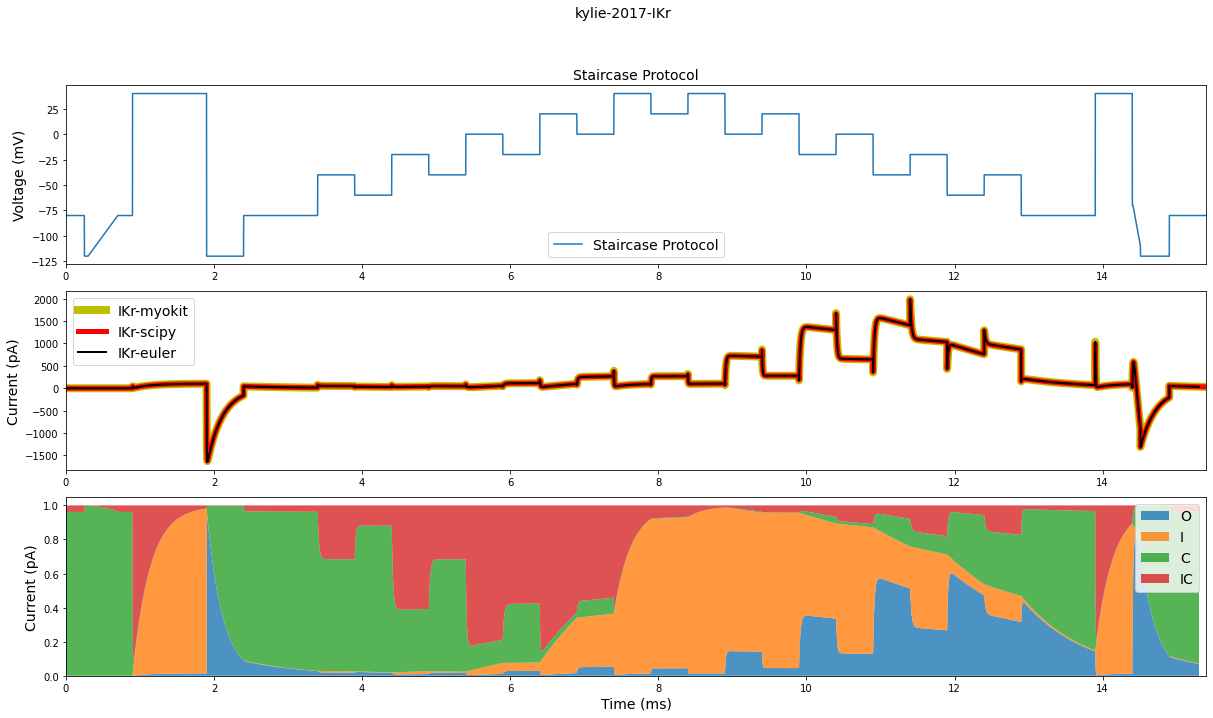

Complete


In [18]:
fig, axes = plt.subplots(3, figsize=(18, 10))
fig.suptitle(sim_myokit.name, fontsize=14)
axes[0].set_title("Staircase Protocol", fontsize=14)
axes[0].set_xlim(0, t_eval[-1])
axes[0].set_ylabel("Voltage (mV)", fontsize=14)
axes[0].plot( t_eval, d_myokit['membrane.V']*1000, label="Staircase Protocol")
# textstr = "GNa : %1.4f\nGNaL : %1.4f\nGto : %1.4f\nPCa : %1.4f\nGKr : %1.4f\nGKs : %1.4f\nGK1 : %1.4f\nGf : %1.4f"%(Gs[0], Gs[1], Gs[2], Gs[3], Gs[4], Gs[5], Gs[6], Gs[7])
# props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# axes[0].text(0.67, 0.60, textstr, transform=axs[0].transAxes, fontsize=14, verticalalignment='top', bbox=props)    
axes[0].legend(fontsize=14)
axes[0].xaxis.set_visible(True)

axes[1].set_xlim(0, t_eval[-1])
axes[1].set_ylabel("Current (pA)", fontsize=14)
axes[1].plot(t_eval, d_myokit['ikr.IKr'], label="IKr-myokit", linewidth=8, color='y')
axes[1].plot(m_scipy.times, m_scipy.IKr, label="IKr-scipy", linewidth=5, color='r')
axes[1].plot(m_euler.times, m_euler.IKr, label="IKr-euler", linewidth=2, color='k')
axes[1].legend(fontsize=14)
axes[1].xaxis.set_visible(True)

axes[2].set_xlim(0, t_eval[-1])
axes[2].set_xlabel("Time (ms)", fontsize=14)
axes[2].set_ylabel("Current (pA)", fontsize=14)
axes[2].stackplot(m_euler.times, population_by_continent.values(), labels=population_by_continent.keys(), alpha=0.8)
axes[2].legend(fontsize=14)
axes[2].xaxis.set_visible(True)

plt.subplots_adjust(left=0.07, bottom=0.05, right=0.95, top=0.87, wspace=0.5, hspace=0.15)
# fig.tight_layout()#rect=[0.5, 0.5, 0.5, 0.5]
plt.show()
fig.savefig(os.path.join('Results', 'Kylie2017IKr_VC.jpg'), dpi=100)
print("Complete")

In [ ]:
# VC_protocol = jk_protocols.VoltageClampProtocol()  # steps=steps
# tpre  = 0.2           # Time before step to variable V
# tstep = 0.5           # Time at variable V
# tpost = 0.1           # Time after step to variable V
# vhold = -80e-3
# vmin = -60e-3#-100e-3
# vmax = 40e-3
# vres = 20e-3        # Difference in V between steps
# v = np.arange(vmin, vmax + vres, vres)
# # Leak estimate
# VC_protocol.add( jk_protocols.VoltageClampStep(voltage=vhold, duration=0.25) )
# VC_protocol.add( jk_protocols.VoltageClampStep(voltage=-120e-3, duration=0.05) )
# VC_protocol.add( jk_protocols.VoltageClampRamp(voltage_start=-0.12, voltage_end=-0.08, duration=0.4)) # ramp step
# # Staircase
# VC_protocol.add( jk_protocols.VoltageClampStep(voltage=vhold, duration=0.2) )
# VC_protocol.add( jk_protocols.VoltageClampStep(voltage=40e-3, duration=1.0) )
# VC_protocol.add( jk_protocols.VoltageClampStep(voltage=-120e-3, duration=0.5) )
# VC_protocol.add( jk_protocols.VoltageClampStep(voltage=vhold, duration=1.0) )
# for vstep in v[1::]:
#     VC_protocol.add( jk_protocols.VoltageClampStep(voltage=vstep, duration=tstep) )
#     VC_protocol.add( jk_protocols.VoltageClampStep(voltage=vstep-vres, duration=tstep) )    
# for vstep in v[::-1][:-1]:
#     VC_protocol.add( jk_protocols.VoltageClampStep(voltage=vstep, duration=tstep) )
#     VC_protocol.add( jk_protocols.VoltageClampStep(voltage=vstep-2*vres, duration=tstep) )    
# VC_protocol.add( jk_protocols.VoltageClampStep(voltage=vhold, duration=1.0 - tstep) )    # extend a bit the ending...
# # EK estimate
# VC_protocol.add( jk_protocols.VoltageClampStep(voltage=40e-3, duration=tstep) )
# VC_protocol.add( jk_protocols.VoltageClampStep(voltage=-70e-3, duration=10e-3) )  # Michael's suggestion
# VC_protocol.add( jk_protocols.VoltageClampRamp(voltage_start=-70e-3, voltage_end=-110e-3, duration=0.1))  # second ramp step  
# VC_protocol.add( jk_protocols.VoltageClampStep(voltage=-120e-3, duration=tstep-10e-3-10e-3) ) # ???
# VC_protocol.add( jk_protocols.VoltageClampStep(voltage=vhold, duration=100) )

# duration = VC_protocol.get_voltage_change_endpoints()[-1]
# times = np.arange(0, 15.4, 0.001)
# VC_protocol.plot_voltage_clamp_protocol(times, unit='s')
# voltages = VC_protocol.get_voltage_clamp_protocol(times)
# print(VC_protocol)